# Shallow Neural Network: 2D Data Classifier

Given a dataset $(X, Y)$, $X$ a $2$-row matrix where the first row stores the $x$ component and the second the $y$ component and $Y$ a vector labeling each set of coordinates in $X$ as either $0$ (red) or $1$ (blue), we want to implement a neural network with a single hidden layer that will classify 2D regions as either red or blue.

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

from testCases_v2 import *
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) #for result consistency

### 1. Load dataset

shape of X: (2, 400)
shape of Y: (1, 400)
training set size (number of examples): 400


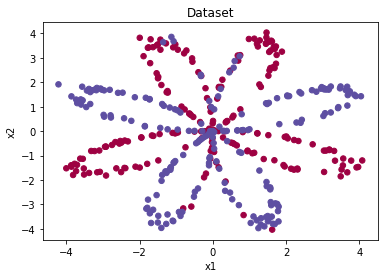

In [69]:
X, Y = load_planar_dataset()  #data from the course
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]                #training set size
plt.scatter(X[0, :], X[1, :], c = Y, s = 30, cmap=plt.cm.Spectral)
plt.ylabel("x2")
plt.xlabel("x1")
plt.title("Dataset")

print("shape of X: " + str(shape_X))
print("shape of Y: " + str(shape_Y))
print("training set size (number of examples): " + str(m))

### 2. Model 

<img src="images/classification_kiank.png" style="width:600px;height:300px;">

Notation: $u^{(i)}$ refers to the $i^{th}$ example of $u$, $u^{[i]}$ is the reference of $u$ in the $i^{th}$ layer of the neural network (as pictured above).

We define the model mathematically as follows:

For each $x^{i}$ in $X$, $i \in \{1, ..., 400\}$, we compute:

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}$$

We also compute the cost function $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small $$

### 3. Algorithm

#### a. NN structure

In [16]:
def layer_sizes(X, Y, neurons):
    n_x = X.shape[0]     #size of first layer: number of features, in the image above, 2
    n_h = neurons        #size of second (hidden) layer: in the image above, 4
    n_y = Y.shape[0]     #size of third (output) layer: in the image above, 1
    return (n_x, n_h, n_y)

#### b. Initializing parameters W1, b1, W2, b2

We initialize the parameters $W1, W2$ of shape ($n_i, n_{i-1}$) with random values, and $b1, b2$ of shape ($n_i, 1$) with zeros.

In [19]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2) 

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

#### c. Forward propagation

In [22]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)          #use tanh for the first activation function (data is more centered)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)          #use sigmoid for the second activation function (output between 0 and 1)

    assert(A2.shape == (1, X.shape[1]))
    
    saved_data = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, saved_data

#### d. Implement cost 

In [29]:
def cost(A2, Y):
    m = Y.shape[1]   #number of examples

    #cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1 - A2), 1 - Y)
    cost = - (1 / m) * np.sum(logprobs)
    cost = float(np.squeeze(cost)) 
    
    return cost

#### e. Backward propagation

<img src="images/grad_summary.png" style="width:600px;height:300px;">
We use the formulas we calculated in the course described above (where $*$ denotes elementwise multiplication)

In [30]:
def backward_propagation(parameters, saved_data, X, Y):
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    A1 = saved_data["A1"]
    A2 = saved_data["A2"]

    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

#### f. Update parameters

Here, $\alpha$ (alpha) is the learning rate.

In [34]:
def update_parameters(parameters, grads, alpha = 1.2):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 4. Build model


In [75]:
def nn_model(X, Y, n_h, num_iterations = 10000, show_cost = False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y, n_h)[0]
    n_y = layer_sizes(X, Y, n_h)[2]
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(num_iterations):
        #forward propagation
        A2, saved_data = forward_propagation(X, parameters)
        
        #cost function
        cost_fct = cost(A2, Y)
 
        #backward propagation
        grads = backward_propagation(parameters, saved_data, X, Y)
 
        #update parameters (gradient descent)
        parameters = update_parameters(parameters, grads)
        
        if show_cost:
            if not i % 1000:
                print("cost at iteration " + str(i) + ": " + str(cost_fct))
            
    return parameters

### 5. Predictions

We can now predict $y_i$ by setting it to $0$ if $a_i \leq 0.5$ and $1$ otherwise. 

In [76]:
def predict(parameters, X):
    A2, _ = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    return predictions

We now run the model on the dataset, using a 4-neuron hidden layer.

cost at iteration 0: 0.6930480201239823
cost at iteration 1000: 0.2880832935690184
cost at iteration 2000: 0.25438549407324557
cost at iteration 3000: 0.23386415038952207
cost at iteration 4000: 0.2267924874485401
cost at iteration 5000: 0.22264427549299015
cost at iteration 6000: 0.21973140404281322
cost at iteration 7000: 0.21750365405131297
cost at iteration 8000: 0.21947125887325217
cost at iteration 9000: 0.21861159124673285
Accuracy: 90%


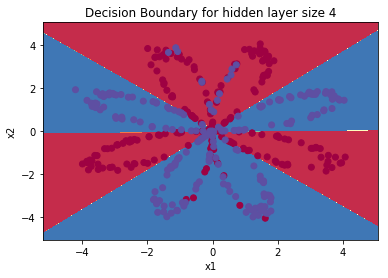

In [77]:
parameters = nn_model(X, Y, 4, num_iterations = 10000, show_cost = True)

#plot
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

#check accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

### 5. Conclusions and further analysis 

We can observe that the accuracy is really high (especially compared to the logistic regression we implemented previously, which with this dataset outputs an accuracy of 47%). To further analyse, we experiment with different hidden layer sizes and other datasets.

#### a. Hidden layers of different sizes

Accuracy for 1 neurons: 67.5 %
Accuracy for 2 neurons: 67.25 %
Accuracy for 3 neurons: 90.75 %
Accuracy for 4 neurons: 90.5 %
Accuracy for 5 neurons: 91.25 %
Accuracy for 20 neurons: 90.0 %


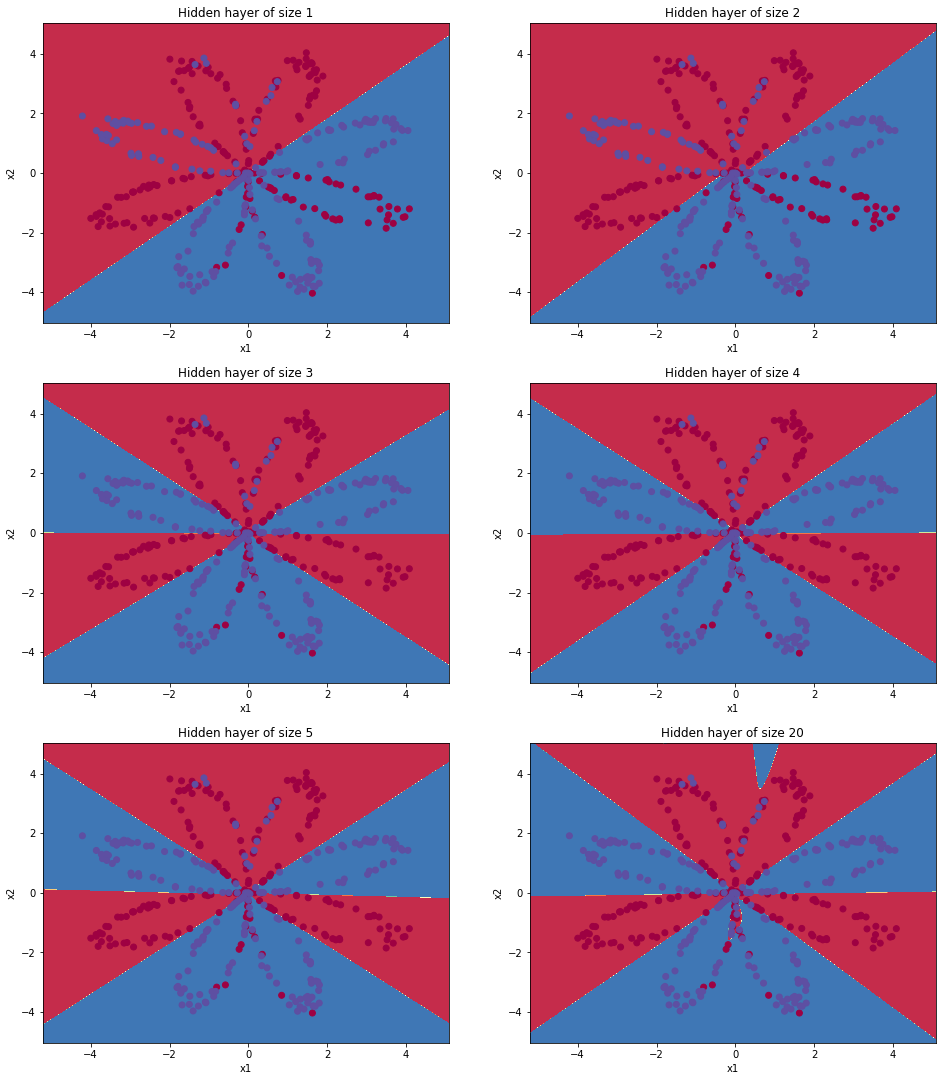

In [79]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden hayer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} neurons: {} %".format(n_h, accuracy))

We can observe that the more neurons in the hidden layer the more accurate the model becomes, up until a certain point. For example, with the size of the hidden layer equal to $20$, we can start observing overfitting, thus the accuracy is decreasing.

#### b. Another set of data

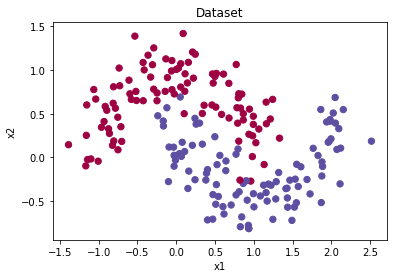

In [81]:
#other datasets
noisy_circles, noisy_moons, _, gaussian_quantiles, no_structure = load_extra_datasets()

dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
plt.ylabel("x2")
plt.xlabel("x1")
plt.title("Dataset")

By rerunning the notebook, we can observe the model working on the new data set. 

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/